In [116]:
import matplotlib.pyplot as plt
from stardist.models import StarDist3D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.segmentation import relabel_sequential
from tifffile import imread
from stardist.matching import matching, matching_dataset, group_matching_labels
from tqdm import tqdm
from skimage.segmentation import relabel_sequential
import statistics
import surface_distance

import sys
import os
from pathlib import Path

cwd = os.getcwd()
print(f"Working dir: {cwd}")
module_path = os.path.abspath(Path(cwd).parents[2])
print(f"Project dir: {module_path}")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.tools.utils import load_yaml, get_tensorboard_logs
from src.data.preprocess_utils import load_files, resample_crop_downsample
from src.models.stardist3D import stardist_predict, threshold_optimization
from src.evaluation.evaluate_models import get_boundary_based_metrics_per_object
import seaborn as sns

sns.set(font_scale=1.2)
sns.set_palette("Set2")

Working dir: C:\Users\lazi257c\Projects\organoid-segmentation-ML\notebooks\results\Simple_Watershed
Project dir: C:\Users\lazi257c\Projects\organoid-segmentation-ML


In [117]:
exp_dir = os.path.join(module_path, "experiments", "exp16_only_watershed")
Path(os.path.join(module_path, "reports", "figures", "watershed")).mkdir(parents=True, exist_ok=True)   # create dir to save figures

## Load predictions

In [7]:
predictions1= load_files(os.path.join(exp_dir, "results_sigma5_outline2"))

Loading files with step size: 1 from D:\Alf_Honigmann_mESC_LightSheet\organoid-segmentation-ML\experiments\exp16_only_watershed\results_sigma5_outline2


In [5]:
predictions2 = load_files(os.path.join(exp_dir, "results_sigma5_outline2", "matched", "postprocessed"))

Loading files with step size: 1 from D:\Alf_Honigmann_mESC_LightSheet\organoid-segmentation-ML\experiments\exp16_only_watershed\results_sigma5_outline2\matched\postprocessed


In [29]:
predictions2_1 = load_files(os.path.join(exp_dir, "results_sigma5_outline2", "matched", "postprocessed","matched",  "smoothed"))

Loading files with step size: 1 from D:\Alf_Honigmann_mESC_LightSheet\organoid-segmentation-ML\experiments\exp16_only_watershed\results_sigma5_outline2\matched\postprocessed\matched\smoothed


In [38]:
predictions3 = load_files(os.path.join(exp_dir, "results_sigma5_outline2", "matched","postprocessed","matched", "smoothed", "removed_2nd"))

Loading files with step size: 1 from D:\Alf_Honigmann_mESC_LightSheet\organoid-segmentation-ML\experiments\exp16_only_watershed\results_sigma5_outline2\matched\postprocessed\matched\smoothed\removed_2nd


## Load GT and compute Metrics

In [8]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [9]:
y_true, fnames = load_files(os.path.join(module_path, "data", "matched_test_set", "isotropic"), return_fnames=True)

Loading files with step size: 1 from D:\Alf_Honigmann_mESC_LightSheet\organoid-segmentation-ML\data\matched_test_set\isotropic


In [10]:
metrics1 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions1).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:11<00:00, 34.60s/it]


In [11]:
metrics2 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions2).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:53<00:00, 32.63s/it]


In [30]:
metrics2_1 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions2_1).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:06<00:00, 34.03s/it]


## Metrics Plots

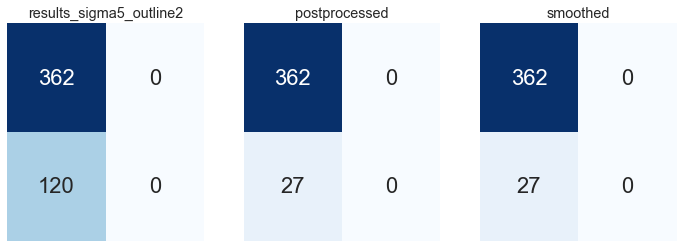

In [121]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
labels = ["results_sigma5_outline2", "postprocessed", "smoothed"]
metrics = [metrics1[3], metrics2[3], metrics2_1[3]]
for met, ax,lbl in zip(metrics, axes.flatten(), labels):
    cm_data_1 = []
    cm_data_2 = []

    for m in ('tp', 'fn', 'fp'):
        if m == "tp" or m == "fn":
            cm_data_1.append(met._asdict()[m])
        elif m == "fp":
            cm_data_2.append(met._asdict()[m])
            
    cm_data_2.append(0)  # tn are not known
    cm_data = [cm_data_1, cm_data_2]
    sns.heatmap(cm_data, annot=True, vmax = 360, cmap='Blues', fmt='d', xticklabels=False, yticklabels=False, ax=ax, cbar = False, annot_kws={'fontsize': 22})
    ax.title.set_text(lbl)
    
plt.savefig(os.path.join(module_path, "reports", "figures", "watershed", "simple_wt_postprocessed_cm.png"), bbox_inches='tight')

In [19]:
metrics_combined = {}

for m in ('tp', 'fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_matched_score", "panoptic_quality"):
    metrics_combined[m] = metrics1[2]._asdict()[m]

In [60]:
metrics_combined.update(
{
    'Mean distance from the GT to predicted surface in microns': res_df["avrg_d_from_gt_to_pred"].mean(),
    "Mean distance from predicted to the GT surface in microns": res_df["avrg_d_from_pred_to_gt"].mean(),
    "Mean Hausdorff95 distance": res_df["HD95"].mean(),
    "Mean surface overlap fraction of GT surfaces with predicted surfaces": res_df["surf_overlap_of_gt_surf_w_pred_surf"].mean(),
    "Mean surface overlap fraction of the predicted surfaces with the GT surfaces": res_df["surf_overlap_of_pred_surf_w_gt_surf"].mean(),
    "Mean surface DSC": res_df["DSCsurf"].mean(),
    "Mean volume DSC over matched objects": res_df["DSCvol"].mean(),
}
)

In [91]:
metrics_combined2 = {}

for m in ('tp', 'fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_matched_score", "panoptic_quality"):
    metrics_combined2[m] = metrics2[2]._asdict()[m]
    

In [92]:
metrics_combined2.update(
{
    'Mean distance from the GT to predicted surface in microns': res_df2["avrg_d_from_gt_to_pred"].mean(),
    "Mean distance from predicted to the GT surface in microns": res_df2["avrg_d_from_pred_to_gt"].mean(),
    "Mean Hausdorff95 distance": res_df2["HD95"].mean(),
    "Mean surface overlap fraction of GT surfaces with predicted surfaces": res_df2["surf_overlap_of_gt_surf_w_pred_surf"].mean(),
    "Mean surface overlap fraction of the predicted surfaces with the GT surfaces": res_df2["surf_overlap_of_pred_surf_w_gt_surf"].mean(),
    "Mean surface DSC": res_df2["DSCsurf"].mean(),
    "Mean volume DSC over matched objects": res_df2["DSCvol"].mean(),
}
)

In [86]:
metrics_combined2_1 = {}

for m in ('tp', 'fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_matched_score", "panoptic_quality"):
    metrics_combined2_1[m] = metrics2_1[2]._asdict()[m]

In [87]:
metrics_combined2_1.update(
{
    'Mean distance from the GT to predicted surface in microns': res_df2_1["avrg_d_from_gt_to_pred"].mean(),
    "Mean distance from predicted to the GT surface in microns": res_df2_1["avrg_d_from_pred_to_gt"].mean(),
    "Mean Hausdorff95 distance": res_df2_1["HD95"].mean(),
    "Mean surface overlap fraction of GT surfaces with predicted surfaces": res_df2_1["surf_overlap_of_gt_surf_w_pred_surf"].mean(),
    "Mean surface overlap fraction of the predicted surfaces with the GT surfaces": res_df2_1["surf_overlap_of_pred_surf_w_gt_surf"].mean(),
    "Mean surface DSC": res_df2_1["DSCsurf"].mean(),
    "Mean volume DSC over matched objects": res_df2_1["DSCvol"].mean(),
}
)

In [94]:
metrics1_df = pd.DataFrame.from_dict(metrics_combined,orient='index',columns=["results_sigma5_outline2"])
metrics2_df = pd.DataFrame.from_dict(metrics_combined2,orient='index',columns=["postprocessed"])
metrics2_1_df = pd.DataFrame.from_dict(metrics_combined2_1,orient='index',columns=["smoothed"])
df = pd.concat([metrics1_df, metrics2_df, metrics2_1_df], axis=1)
df.T

,tp,fn,fp,precision,recall,accuracy,f1,mean_matched_score,panoptic_quality,Mean distance from the GT to predicted surface in microns,Mean distance from predicted to the GT surface in microns,Mean Hausdorff95 distance,Mean surface overlap fraction of GT surfaces with predicted surfaces,Mean surface overlap fraction of the predicted surfaces with the GT surfaces,Mean surface DSC,Mean volume DSC over matched objects
results_sigma5_outline2,362.0,0.0,120.0,0.751037,1.0,0.751037,0.857820,0.769906,0.660441,0.503010,0.404890,1.455244,0.703077,0.803772,0.747952,0.867087
postprocessed,362.0,0.0,27.0,0.930591,1.0,0.930591,0.964048,0.791027,0.762588,0.444350,0.374581,1.143888,0.718121,0.815638,0.761870,0.881737
smoothed,362.0,0.0,27.0,0.930591,1.0,0.930591,0.964048,0.792402,0.763913,0.449848,0.368691,1.153647,0.718663,0.822868,0.765128,0.882560


In [95]:
print(df.T.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
{} &     tp &   fn &     fp &  precision &  recall &  accuracy &        f1 &  mean\_matched\_score &  panoptic\_quality &  Mean distance from the GT to predicted surface in microns &  Mean distance from predicted to the GT surface in microns &  Mean Hausdorff95 distance &  Mean surface overlap fraction of GT surfaces with predicted surfaces &  Mean surface overlap fraction of the predicted surfaces with the GT surfaces &  Mean surface DSC &  Mean volume DSC over matched objects \\
\midrule
results\_sigma5\_outline2 &  362.0 &  0.0 &  120.0 &   0.751037 &     1.0 &  0.751037 &  0.857820 &            0.769906 &          0.660441 &                                           0.503010 &                                           0.404890 &                   1.455244 &                                           0.703077 &                                           0.803772 &          0.747952 &                              0.867087 \\
postprocessed    

3761838652.py (1): In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Boundary based metrics

In [34]:
# tolerance is 3 pixels, values provided in mm because Surface Distance library has in the documentation mm. Returned values are already in microns
res_df = get_boundary_based_metrics_per_object(predictions1, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)

Computing surface distances dict for each label: 100%|█████████████████████████████████| 35/35 [04:26<00:00,  7.60s/it]
metrics.py (317): invalid value encountered in double_scalars
metrics.py (319): invalid value encountered in double_scalars
metrics.py (388): invalid value encountered in double_scalars
metrics.py (391): invalid value encountered in double_scalars
metrics.py (421): invalid value encountered in double_scalars


In [58]:
res_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # replace infinite values with nan, they are due to FP

In [89]:
# tolerance is 3 pixels, values provided in mm because Surface Distance library has in the documentation mm. Returned values are already in microns
res_df2 = get_boundary_based_metrics_per_object(predictions2, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)

Computing surface distances dict for each label: 100%|█████████████████████████████████| 35/35 [04:26<00:00,  7.63s/it]
metrics.py (317): invalid value encountered in double_scalars
metrics.py (319): invalid value encountered in double_scalars
metrics.py (388): invalid value encountered in double_scalars
metrics.py (391): invalid value encountered in double_scalars
metrics.py (421): invalid value encountered in double_scalars


In [90]:
res_df2.replace([np.inf, -np.inf], np.nan, inplace=True)  # replace infinite values with nan, they are due to FP

In [65]:
# tolerance is 3 pixels, values provided in mm because Surface Distance library has in the documentation mm. Returned values are already in microns
res_df2_1 = get_boundary_based_metrics_per_object(predictions2_1, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)

Computing surface distances dict for each label: 100%|█████████████████████████████████| 35/35 [04:30<00:00,  7.74s/it]
metrics.py (317): invalid value encountered in double_scalars
metrics.py (319): invalid value encountered in double_scalars
metrics.py (388): invalid value encountered in double_scalars
metrics.py (391): invalid value encountered in double_scalars
metrics.py (421): invalid value encountered in double_scalars


In [85]:
res_df2_1.replace([np.inf, -np.inf], np.nan, inplace=True)  # replace infinite values with nan, they are due to FP

In [98]:
res_df_all = pd.concat([res_df, res_df2, res_df2_1], axis=1)

In [100]:
res_df_all.to_csv(r"metrics/exp16_postprocessed_distance_metrics_df.csv")

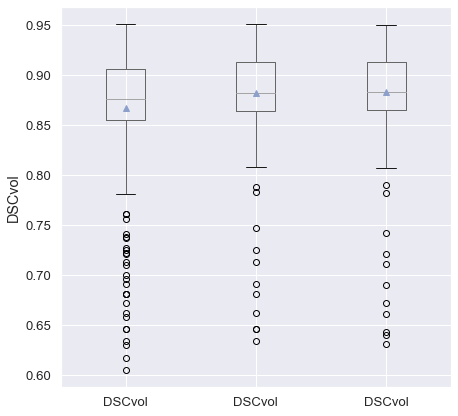

In [118]:
f, ax = plt.subplots(1, figsize = (7,7))
sns.set(font_scale=1.2)
sns.set_palette("Set2")
res_df_all.boxplot(column="DSCvol", showmeans=True,ax=ax)
ax.set_ylabel("DSCvol")

plt.savefig(os.path.join(module_path, "reports", "figures", "watershed", "exp16_postprocessed_distance_metrics_boxplot_DSCvol.png"), bbox_inches='tight')

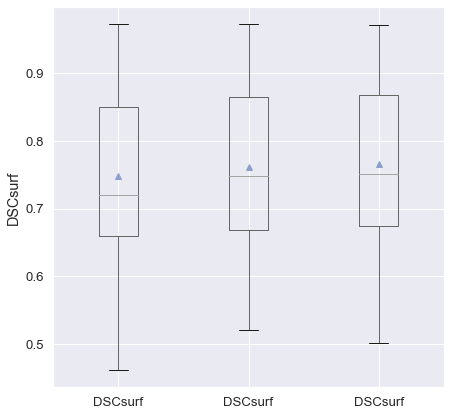

In [119]:
f, ax = plt.subplots(1, figsize = (7,7))
sns.set(font_scale=1.2)
sns.set_palette("Set2")
res_df_all.boxplot(column="DSCsurf", showmeans=True,ax=ax)
ax.set_ylabel("DSCsurf")

plt.savefig(os.path.join(module_path, "reports", "figures", "watershed", "exp16_postprocessed_distance_metrics_DSCsurf.png"), bbox_inches='tight')

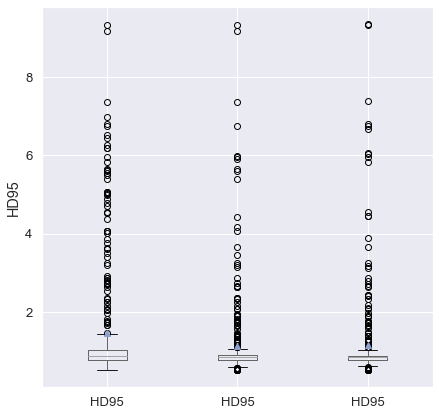

In [120]:
f, ax = plt.subplots(1, figsize = (7,7))
sns.set(font_scale=1.2)
sns.set_palette("Set2")
res_df_all.boxplot(column="HD95", showmeans=True,ax=ax)
ax.set_ylabel("HD95")

plt.savefig(os.path.join(module_path, "reports", "figures", "watershed", "exp16_postprocessed_distance_metrics_boxplot_HD95.png"), bbox_inches='tight')